## GNR 650 - Advanced topics in deep learning for image analysis
### Assignment 1: ResNet-18 on CIFAR10 with few training samples per class
> The task is to take the structure of ResNet-18 model, and train it from scratch on CIFAR10 data, but take very few samples per class. After training, check the test performance. Check the magnitudes of the weights, visualize the kernels at different layers.

### Imporing Libraries

In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

### Hyperparameters

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
inv_mean = -mean
inv_std = 1/std
max_n = 100
batch_size = 32
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 40
print_summary = False

### Preprocessing & Data Augmentation

In [3]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

# For the purposes of visualizing images
inv_transforms = transforms.Compose([transforms.Normalize(mean = (0., 0., 0.),
                                                          std = inv_std),
                                     transforms.Normalize(mean = inv_mean,
                                                          std = (1., 1., 1,))])

cifar10 = datasets.CIFAR10(root = './data/', train=True, transform=train_transforms, download=True)
cifar10_test = datasets.CIFAR10(root='./data/', train=False, transform=test_transforms, download=True)
cifar10_classes = cifar10.classes
images, labels = cifar10.data, np.array(cifar10.targets)
test_images, test_labels = cifar10_test.data, np.array(cifar10_test.targets)

Files already downloaded and verified
Files already downloaded and verified


### Visualizing CIFAR 10 Dataset

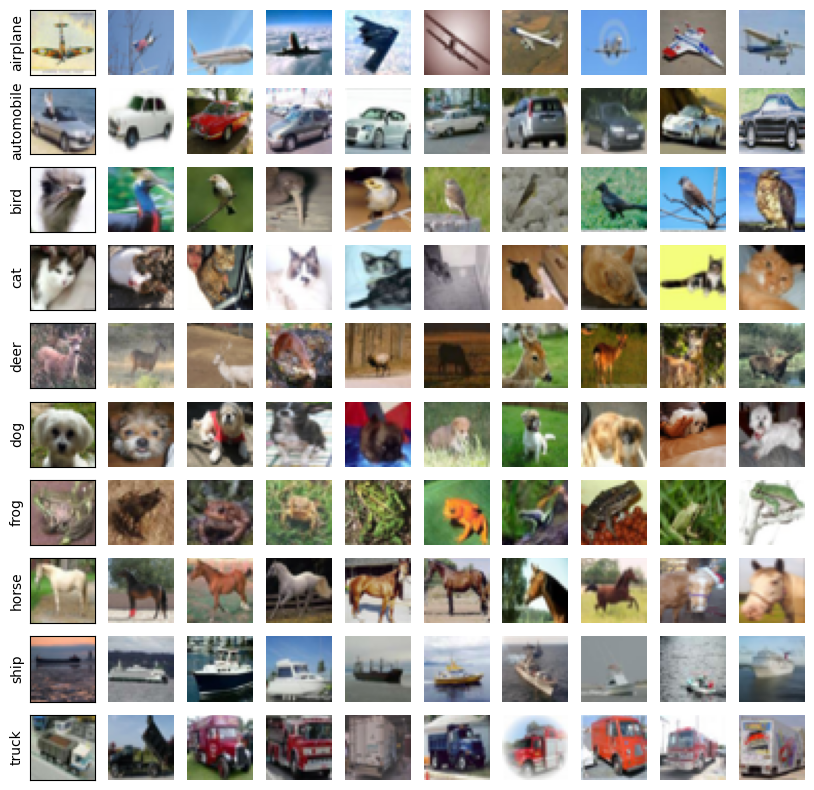

In [4]:
num_per_class = 10
fig, axes = plt.subplots(nrows=num_per_class, ncols=len(cifar10_classes), figsize = (10,10))
for idx, cls_name in enumerate(cifar10_classes):
    lbl_idxs = np.where(labels == idx)[0]
    for row in range(num_per_class):
        disp_idx = random.choice(lbl_idxs)
        img = images[disp_idx]
        axes[idx][row].imshow(img)
        if row == 0:
            axes[idx][row].set_ylabel(cls_name)
            axes[idx][row].set_xticks([])
            axes[idx][row].set_yticks([])
            continue
        axes[idx][row].axis('off')

### Preparing Datasets: Subset & Full

In [5]:
data_idxs_subset = []                           # 100 training images per class
data_idxs_full = []                             # 5000 training images per class
for idx, _ in enumerate(cifar10_classes):   
    lbl_idxs = np.where(labels == idx)[0]
    idxs_subset = np.random.choice(lbl_idxs, max_n, replace=False)
    data_idxs_subset.extend(idxs_subset)
    data_idxs_full.extend(lbl_idxs)
print("Size of subset dataset: ", len(data_idxs_subset))        # 100 x 10 = 1000
print("Size of full dataset: ", len(data_idxs_full))            # 5000 x 10 = 5000

Size of subset dataset:  1000
Size of full dataset:  50000


### Preparing CIFAR 10 Dataloader

In [6]:
class Cifar10(Dataset):
    def __init__(self, images, labels, idxs, transform = None):
        self.images = images[idxs]
        self.labels = labels[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            if not isinstance(img, torch.Tensor):
                img = Image.fromarray(img)
                img = self.transform(img)
        return img, lbl
    
# Create two datasets, one for subset and one for full
train_dataset_subset = Cifar10(images, labels, data_idxs_subset, train_transforms)
train_dataset_full = Cifar10(images, labels, data_idxs_full, train_transforms)
test_dataset = Cifar10(test_images, test_labels, list(range(len(test_images))), test_transforms)
 
# Create DataLoaders
trainloader_subset = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
trainloader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

### Training Function

In [7]:
def train_model(trainloader, testloader, model_name, print_summary, regularize = False):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(cifar10_classes))
    model = model.to(device)
    if print_summary:
        summary(model=model, input_size=(3,32,32))
    criterion = nn.CrossEntropyLoss()
    if regularize:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.05)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    accuracy = []
    test_accuracy = []
    best_test_accuracy = 0.0
    best_train_accuracy = 0.0

    # Save Names
    best_model = f'best_model_{model_name}'
    final_model = f'{model_name}'
    if regularize:
        best_model+='_regularize'
        final_model+='_regularize'

    print(f"Training {model_name}")
    for epoch in range(1, epochs+1):
        pbar = tqdm(trainloader, total=len(trainloader), leave=False)
        epoch_loss = 0.0
        model.train()
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(train_loss=loss.item())

        epoch_loss = epoch_loss / len(trainloader)
        model.eval()
        no_of_correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in trainloader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                _, preds = out.max(-1)
                no_of_correct += (preds == lbls).cpu().numpy().sum()
                total += len(lbls)

        epoch_accuracy = no_of_correct / total
        losses.append(epoch_loss)
        accuracy.append(epoch_accuracy)


        no_of_correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in testloader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                _, preds = out.max(-1)
                no_of_correct += (preds == lbls).cpu().numpy().sum()
                total += len(lbls)

        test_epoch_accuracy = no_of_correct / total
        test_accuracy.append(test_epoch_accuracy)
        if best_test_accuracy < test_epoch_accuracy:
            best_test_accuracy = test_epoch_accuracy
            torch.save(model.state_dict(), f'./model_weights/{best_model}.pt')
        if best_train_accuracy < epoch_accuracy:
            best_train_accuracy = epoch_accuracy
            torch.save(model.state_dict(), f'./model_weights/{final_model}.pt')

        print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_loss:5.3f}, Train Accuracy: {epoch_accuracy*100:5.2f}
{"#"*33}''')
    model.load_state_dict(torch.load(f'./model_weights/{final_model}.pt'))
    return model,losses,accuracy,test_accuracy

### Training ResNet-18 on CIFAR10 Subset Dataset (100 training samples per class)

In [ ]:
resnet18_subset, losses_subset, \
accuracy_subset, test_accuracy_subset = train_model(trainloader_subset, testloader,
                                                    "ResNet18_Subset", 
                                                    print_summary=print_summary,
                                                    regularize=False)

### Training Regularized ResNet-18 on CIFAR10 Subset Dataset (100 training samples per class)

In [ ]:
resnet18_subset_reg, losses_subset_reg, \
accuracy_subset_reg, test_accuracy_subset_reg = train_model(trainloader_subset, 
                                                    testloader,
                                                    "ResNet18_Subset", 
                                                    print_summary=print_summary,
                                                    regularize=True)

### Training ResNet-18 on CIFAR10 Full Dataset

In [ ]:
resnet18_full, losses_full, \
accuracy_full, test_accuracy_full = train_model(trainloader_full, testloader,
                                                "ResNet18_Full", 
                                                print_summary=print_summary, 
                                                regularize=False)

### Training Regularized ResNet-18 on CIFAR10 Full Dataset

In [ ]:
resnet18_full_reg, losses_full_reg, \
accuracy_full_reg, test_accuracy_full_reg = train_model(trainloader_full, 
                                                testloader,
                                                "ResNet18_Full", 
                                                print_summary=print_summary, 
                                                regularize=True)

### Comparing Training Set Performance

In [12]:
training_accuracy_subset = accuracy_subset[-1]
training_accuracy_full = accuracy_full[-1]
training_accuracy_subset_reg = accuracy_subset_reg[-1]
training_accuracy_full_reg = accuracy_full_reg[-1]
print(f"Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized):\
 {training_accuracy_subset * 100:.2f}%")
print(f"Training Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized):\
 {training_accuracy_full * 100:.2f}%")
print(f"Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized):\
 {training_accuracy_subset_reg * 100:.2f}%")
print(f"Training Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized):\
 {training_accuracy_full_reg * 100:.2f}%")

Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized): 98.00%
Training Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized): 99.02%
Training Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized): 75.30%
Training Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized): 47.62%


### Comparing Test Set Performance

In [13]:
testing_accuracy_subset = test_accuracy_subset[-1]
testing_accuracy_full = test_accuracy_full[-1]
testing_accuracy_subset_reg = test_accuracy_subset_reg[-1]
testing_accuracy_full_reg = test_accuracy_full_reg[-1]
print(f"testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized):\
 {testing_accuracy_subset * 100:.2f}%")
print(f"testing Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized):\
 {testing_accuracy_full * 100:.2f}%")
print(f"testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized):\
 {testing_accuracy_subset_reg * 100:.2f}%")
print(f"testing Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized):\
 {testing_accuracy_full_reg * 100:.2f}%")

testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Non Regularized): 37.72%
testing Accuracy of ResNet18 on full CIFAR10 Dataset (Non Regularized): 76.84%
testing Accuracy of ResNet18 on subset CIFAR10 Dataset (Regularized): 35.01%
testing Accuracy of ResNet18 on full CIFAR10 Dataset (Regularized): 47.69%


### Plotting Training Accuracy and Training Loss (for each experiment)

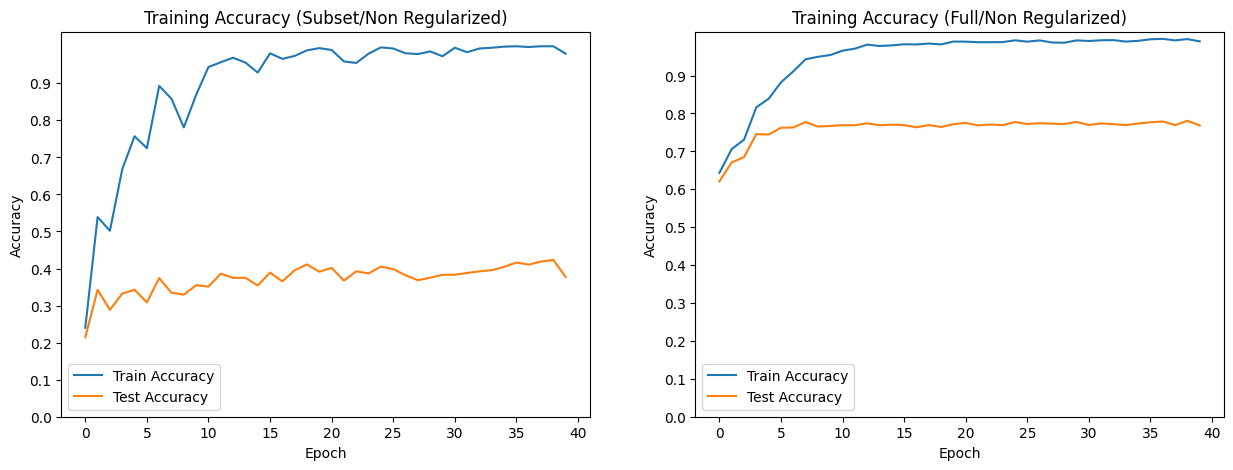

In [22]:
# Plotting accuracy for train and test set
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(accuracy_subset, label="Train Accuracy")
axes[0].plot(test_accuracy_subset, label="Test Accuracy")
axes[0].set_title('Training Accuracy (Subset/Non Regularized)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(accuracy_full, label="Train Accuracy")
axes[1].plot(test_accuracy_full, label="Test Accuracy")
axes[1].set_title('Training Accuracy (Full/Non Regularized)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_yticks(np.arange(0.0, 1.0, 0.1))

plt.show()

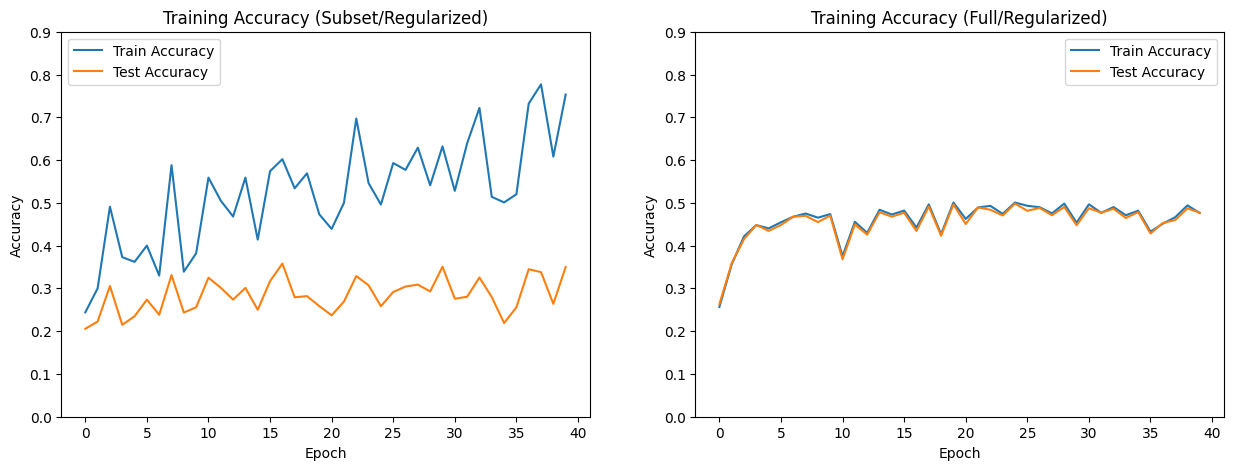

In [23]:
# Plotting accuracy for train and test set
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(accuracy_subset_reg, label="Train Accuracy")
axes[0].plot(test_accuracy_subset_reg, label="Test Accuracy")
axes[0].set_title('Training Accuracy (Subset/Regularized)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(accuracy_full_reg, label="Train Accuracy")
axes[1].plot(test_accuracy_full_reg, label="Test Accuracy")
axes[1].set_title('Training Accuracy (Full/Regularized)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[1].legend()

plt.show()

### Comparing Weight Distributions

In [ ]:
best_subset = models.resnet18(weights=None)
best_subset.fc = nn.Linear(best_subset.fc.in_features, len(cifar10_classes))
best_subset = best_subset.to(device)

In [ ]:
subset_best_path = './model_weights/best_model_ResNet18_Subset.pt'
best_subset.load_state_dict(torch.load(subset_best_path))
models = [resnet18_subset, best_subset]
model_names = ["Overfit (Subset)", "Not Overfit (Subset)"]

fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(12, 36))
conv_layer = 1

for layer_index in range(18):
    for model_index, model in enumerate(models):
        current_layer = None
        layer_count = 0
        for layer in model.named_modules():
            if layer[0].find('conv') != -1:
                if layer_count == layer_index:
                    current_layer = layer
                    break
                layer_count += 1
            elif layer[0].find('fc') != -1 and layer_index == 17:  
                current_layer = layer
                break
        
        if current_layer:
            layer_weights = current_layer[1].weight.cpu().detach().clone().numpy().reshape(-1, 1)
            if current_layer[0].find('conv') != -1:
                title = f"Conv Layer {conv_layer} Weights"
                if model_index == 1:
                    conv_layer += 1
            else:
                title = f"FC Layer Weights"
            if layer_index == 0:
                title = f"{model_names[model_index]}\n{title}"
            sns.distplot(x=layer_weights, ax=axes[layer_index, model_index]).set(title=title)
            axes[layer_index, model_index].set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [ ]:
full_best_path = './model_weights/best_model_ResNet18_Full.pt'
best_full = model.load_state_dict(torch.load(full_best_path))
models = [resnet18_full, best_full]
model_names = ["Overfit (Full)", "Not Overfit (Full)"]

fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(12, 36))
conv_layer = 1

for layer_index in range(18):
    for model_index, model in enumerate(models):
        current_layer = None
        layer_count = 0
        for layer in model.named_modules():
            if layer[0].find('conv') != -1:
                if layer_count == layer_index:
                    current_layer = layer
                    break
                layer_count += 1
            elif layer[0].find('fc') != -1 and layer_index == 17:  
                current_layer = layer
                break
        
        if current_layer:
            layer_weights = current_layer[1].weight.cpu().detach().clone().numpy().reshape(-1, 1)
            if current_layer[0].find('conv') != -1:
                title = f"Conv Layer {conv_layer} Weights"
                if model_index == 1:
                    conv_layer += 1
            else:
                title = f"FC Layer Weights"
            if layer_index == 0:
                title = f"{model_names[model_index]}\n{title}"
            sns.distplot(x=layer_weights, ax=axes[layer_index, model_index]).set(title=title)
            axes[layer_index, model_index].set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()